In [1]:
from skimage import img_as_ubyte
from fileSetUtils import *

import matplotlib.pyplot as plt
import numpy as np

In [2]:

marker_dataset = decompress("data/set4.zip")

# Pre Processing Data

- Convert to GrayScale Array
- Add brightness Variants
- Match Postiv and negativ sampeles
- Add Image Noise
- Convert to Vector

                                                  images  label         name  \
768    [[0.11547650284867754, 0.10604260082346613, 0....      1  P_65079.png   
38165  [[0.2675255918688092, 0.25940904533106907, 0.2...      1  P_65008.png   
826    [[0.3573983704635319, 0.3524469445043463, 0.35...      1  P_65315.png   
45882  [[0.3036945143677907, 0.33255084627388065, 0.3...      1  P_64893.png   
5079   [[0.6330085475932614, 0.6413172860999162, 0.63...      1  P_64956.png   
27769  [[0.3966944347100451, 0.3904759700894089, 0.40...      1  P_65307.png   
42321  [[1.0, 0.7106636902804104, 0.4187904423537007,...      1  P_65090.png   
16995  [[0.3847586898669263, 0.4049870069217676, 0.42...      1  P_65381.png   
53259  [[0.2213170565795373, 0.22499321240258785, 0.2...     -1  N_43926.png   
11090  [[0.29309898571769444, 0.2946742023583296, 0.2...     -1  N_19987.png   
48972  [[0.5295921555981438, 0.5322508742486868, 0.56...     -1  N_59614.png   
57798  [[0.3524123259285395, 0.357861889

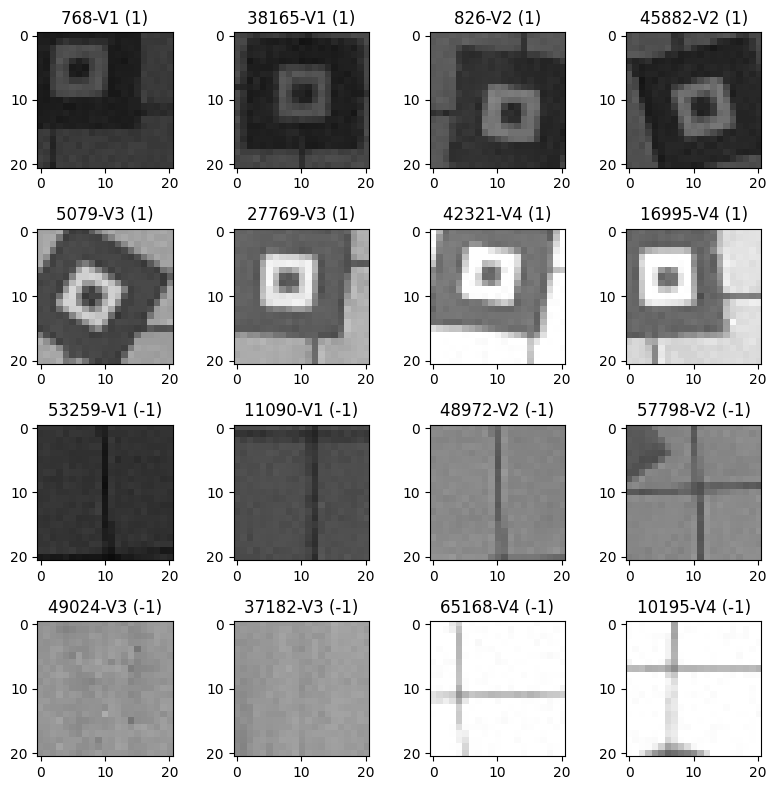

New: 129756 (+64878 -64878, 0.50% 0.50%) | Old: 65451 (+573 -64878, 0.01% 0.99%)


images  label
23290  [[0.40643760463074197, 0.3982520862496269, 0.4...      1
47604  [[0.12182608906416852, 0.19741380979252504, 0....      1
54068  [[0.5783613612865524, 0.4507420836595933, 0.47...      1
43583  [[0.31308472117490954, 0.30893375779528137, 0....      1
56001  [[0.2915222336036848, 0.27913560835588913, 0.2...      1

In [14]:
# Pipeline Functions
def add_additional_col(df: pd.DataFrame) -> pd.DataFrame:
    df["variant"] = 0
    df["id"] = df.index
    return df

def clean_up_image_array(df: pd.DataFrame) -> pd.DataFrame:
    df["images"] = df["images"].apply(lambda x: x[:, :, 0].astype(np.float32) / 255)
    return df

def add_var_brightness(df: pd.DataFrame, levels: list[int]) -> pd.DataFrame:
    new_dfs = [df]
    for n,l in enumerate(levels):
        new_df = df.query("variant == 0").copy()
        new_df["images"] = new_df["images"].apply(lambda x: np.clip(x*l, a_min=0.0, a_max=1.0))
        new_df["variant"] = n+1
        new_dfs.append(new_df)

    return pd.concat(new_dfs)

def match_sample_size(df: pd.DataFrame, size: int) -> pd.DataFrame:
    df_pos = df[df.label ==  1].sample(size//2, replace=True)
    df_neg = df[df.label == -1].sample(size//2, replace=True)
    return pd.concat([df_pos, df_neg])

def add_noise(df: pd.DataFrame, level) -> pd.DataFrame:
    df["images"] = df["images"].apply(lambda x: np.clip(x + np.random.normal(0, level, x.shape), a_min=0.0, a_max=1.0))
    return df

def remove_uncessary_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns=["id", "variant", "name"])

def change_label_values(df: pd.DataFrame) -> pd.DataFrame:
    #df["label"] = df["label"].apply(lambda x: np.array([1, 0]) if x == 1 else np.array([0, 1]))
    df["label"] = df["label"].apply(lambda x: 1 if x == 1 else 0)
    return df

def vectorize_images(df: pd.DataFrame) -> pd.DataFrame:
    #df["images"] = df["images"].apply(lambda x: np.expand_dims(x, axis=2))
    return df

# Collecting before metrics
size_old = marker_dataset.shape[0]
size_old_pos = marker_dataset[marker_dataset.label == 1].shape[0]
size_old_neg = marker_dataset[marker_dataset.label == -1].shape[0]

# Running the main pipeline
marker_dataset_mod = (marker_dataset.copy()
    .pipe(add_additional_col)
    .pipe(clean_up_image_array)
    .pipe(add_var_brightness, levels=[0.5, 0.75, 1.25, 1.5])
    .pipe(match_sample_size, size=size_old_neg*2)
    .pipe(add_noise, level=0.01)
)

# Plotting Sample Data
samples = pd.concat([
    marker_dataset_mod[(marker_dataset_mod.label ==  1) & (marker_dataset_mod.variant == 1)].sample(2, replace=True, random_state=42),
    marker_dataset_mod[(marker_dataset_mod.label ==  1) & (marker_dataset_mod.variant == 2)].sample(2, replace=True, random_state=42),
    marker_dataset_mod[(marker_dataset_mod.label ==  1) & (marker_dataset_mod.variant == 3)].sample(2, replace=True, random_state=42),
    marker_dataset_mod[(marker_dataset_mod.label ==  1) & (marker_dataset_mod.variant == 4)].sample(2, replace=True, random_state=42),
    marker_dataset_mod[(marker_dataset_mod.label == -1) & (marker_dataset_mod.variant == 1)].sample(2, replace=True, random_state=42),
    marker_dataset_mod[(marker_dataset_mod.label == -1) & (marker_dataset_mod.variant == 2)].sample(2, replace=True, random_state=42),
    marker_dataset_mod[(marker_dataset_mod.label == -1) & (marker_dataset_mod.variant == 3)].sample(2, replace=True, random_state=42),
    marker_dataset_mod[(marker_dataset_mod.label == -1) & (marker_dataset_mod.variant == 4)].sample(2, replace=True, random_state=42)
])
print(samples)
fig = plt.figure(figsize=(8, 8))
for i in range(16):
    s = samples.iloc[i]
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title("{}-V{} ({})".format(
        s["id"], 
        s["variant"],
        s["label"]
    ))
    plt.imshow(s["images"], cmap="gray",  vmin=0.0, vmax=1.0)

plt.tight_layout()
plt.show()

# Metrics
size_new = marker_dataset_mod.shape[0]
size_new_pos = marker_dataset_mod[marker_dataset_mod.label == 1].shape[0]
size_new_neg = marker_dataset_mod[marker_dataset_mod.label == -1].shape[0]

# Finalize Data Set
marker_dataset_mod = (marker_dataset_mod
    .pipe(remove_uncessary_cols)
    .pipe(vectorize_images)
    .pipe(change_label_values)
)

print("New: {} (+{} -{}, {:.02f}% {:.02f}%) | Old: {} (+{} -{}, {:.02f}% {:.02f}%)".format(
    size_new, size_new_pos, size_new_neg, size_new_pos/size_new, size_new_neg/size_new,
    size_old, size_old_pos, size_old_neg, size_old_pos/size_old, size_old_neg/size_old,
))
marker_dataset_mod.head()

In [15]:
# Save Data Set
marker_dataset_mod.to_pickle("data/set4.pkl")